<a href="https://colab.research.google.com/github/rnklee/ultrasound-nerve-segmentation/blob/main/nerve_segmentation_exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip install torcheval
! pip install scikit-image
! pip install ipympl

In [ ]:
import sys, os
import re
import time
import pickle

In [ ]:
from tqdm import tqdm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from skimage.metrics import structural_similarity as ssim

from PIL import Image
import cv2

import random, itertools

from collections import OrderedDict
from functools import partial

import pdb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

from torch.utils.data import Dataset, DataLoader, sampler

import torchvision
from torchvision import transforms, models

import segmentation_models_pytorch as smp
import albumentations

import segmentation_models_pytorch.utils.metrics
import segmentation_models_pytorch.utils.losses

# Load data from GitHub

In [ ]:
!git clone https://github.com/rnklee/ultrasound-nerve-segmentation

Cloning into 'ultrasound-nerve-segmentation'...
remote: Enumerating objects: 7991, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 7991 (delta 30), reused 51 (delta 20), pack-reused 7925
Receiving objects: 100% (7991/7991), 1.39 GiB | 26.82 MiB/s, done.
Resolving deltas: 100% (193/193), done.
Updating files: 100% (11299/11299), done.


In [ ]:
%cd ultrasound-nerve-segmentation

/content/ultrasound-nerve-segmentation


In [ ]:
ultrasoundpath = '.'
trainpath = './train/'
datapath = './data/'
modelspath = './models/'

In [ ]:
with open(datapath + '/cleaned_masks.pkl', 'rb') as f:
    masks = pickle.load(f)
with open(datapath + '/cleaned_images.pkl', 'rb') as f:
    images = pickle.load(f)
with open(datapath + '/cleaned_strat.pkl', 'rb') as f:
    stratify = pickle.load(f)

In [ ]:
masks = [o.replace('/content/drive/MyDrive/ultrasound-nerve-segmentation/train', '') for o in masks]
images = [o.replace('/content/drive/MyDrive/ultrasound-nerve-segmentation/train', '') for o in images]

In [ ]:
with open(datapath + '/train_test_msks.pkl', 'rb') as f:
    train_test_msks = pickle.load(f)
with open(datapath + '/train_test_stratify.pkl', 'rb') as f:
    train_test_stratify = pickle.load(f)
with open(datapath + '/test_msks.pkl', 'rb') as f:
    test_msks = pickle.load(f)
with open(datapath + '/train_msks.pkl', 'rb') as f:
    train_msks = pickle.load(f)
with open(datapath + '/valid_msks.pkl', 'rb') as f:
    valid_msks = pickle.load(f)

In [ ]:
# !git config --global user.email "rnklee@terpmail.umd.edu"
# !git config --global user.name "Rachel"
# !git add --all
# !git commit -m 'Implemented combination model'
# !git push 'https://MY_TOKEN@github.com/rnklee/ultrasound-nerve-segmentation.git'

# Necessary definitions

In [ ]:
class NerveDataset(Dataset):
    def __init__(self, mskfiles, color=True, preprocess=None, augment=None, train=True):
        super().__init__()

        self.mskfiles = [trainpath+o for o in mskfiles]
        self.imgfiles = [o.replace('_mask', '') for o in self.mskfiles]

        self.preprocess = preprocess
        self.augment = augment
        self.color = color


    def __len__(self):
        return len(self.mskfiles)


    def __getitem__(self, idx):
        if self.color:
            img = cv2.imread(self.imgfiles[idx])
        else:
            img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment is not None:
            sample = self.augment(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if self.preprocess is not None:
            sample = self.preprocess(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if not self.color:
            img = np.expand_dims(img, axis=0)
        img = img.astype(np.float32)
        msk = (msk/255).astype(np.float32)
        msk = np.expand_dims(msk, axis=0)

        return img, msk

In [ ]:
def has_nerve(mask):
    o = cv2.imread(trainpath+mask, cv2.IMREAD_GRAYSCALE)
    return 1 if o.any() else 0

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')

# 1. Exploratory data analysis

We begin by checking the size of the dataset and the shape of each image.

In [ ]:
len(masks)

5635

In [ ]:
cv2.imread(images[0], cv2.IMREAD_GRAYSCALE).shape

(420, 580)

Also make sure the images look OK.

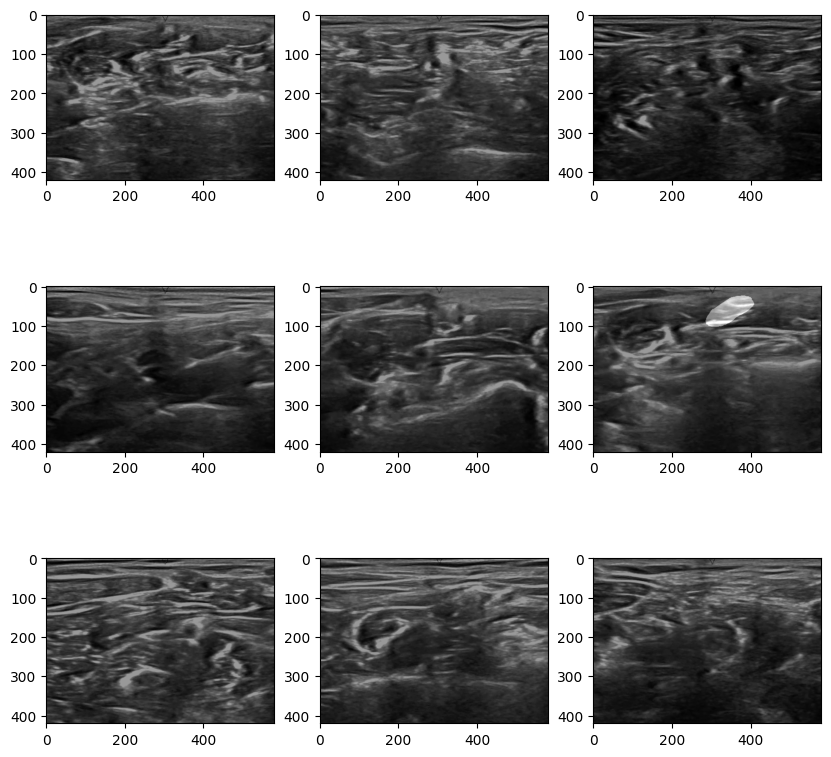

In [ ]:
rows, cols = 3, 3
fig = plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(images))
    fig.add_subplot(rows,cols,i)
    img_path = images[ii]
    msk_path = masks[ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)), alpha=0.4, cmap = 'gray')
plt.show()

## 1.1. Removing duplicates
It was brought up in several Kaggle/blog posts that there are inconsistencies in masks. To resolve this, after finding pairs of images that are similar, I remove an image when its mask does not contain any nerve while its counterpart's mask does ([source](https://www.kaggle.com/code/agalea91/mislabeled-training-images/notebook)). Unlike the source, I use ssim on scaled images to determine whether two images are similar enough (as in this [article](https://medium.com/analytics-vidhya/ultrasound-nerve-segmentation-an-end-to-end-image-segmentation-case-study-ec88bfed0894)). The resulting datasets (consisting of 5496 images) are saved in data folder.

In [ ]:
def find_duplicates(images, masks):
    pairs = []

    msks = []
    imgs = []
    for i in tqdm(range(len(masks))):
        msks.append(cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE))
        imgs.append(cv2.imread(images[i], cv2.IMREAD_GRAYSCALE))

    for i in tqdm(range(len(masks))):
        msk1 = msks[i]
        img1 = cv2.resize(imgs[i], (64,64))
        for j in range(i+1, len(masks)):
            msk2 = msks[j]
            img2 = cv2.resize(imgs[j], (64,64))

            sim = ssim(img1, img2)
            if abs(sim) > 0.99 and msk1.any() != msk2.any():
                pairs.append((i,j))
    return pairs

In [ ]:
dup_pairs = find_duplicates(images, masks)

100%|██████████| 5635/5635 [2:41:47<00:00,  1.72s/it]


In [ ]:
def find_dups(images):
    imgs = []
    pairs = {}

    for i in tqdm(range(len(masks))):
        imgs.append(cv2.imread(images[i], cv2.IMREAD_GRAYSCALE))

    for i in tqdm(range(len(masks))):
        for j in range(i+1, len(masks)):
            if not (imgs[i]-imgs[j]).any():
                if i not in pairs:
                    pairs[i] = [i]
                pairs[i].append(j)

    return pairs

In [ ]:
dup_dict = find_dups(images)

100%|██████████| 5635/5635 [14:21<00:00,  6.54it/s] 


In [ ]:
dice_score = lambda m1, m2: (2.0*np.multiply(m1,m2).sum()+1)/ (m1.sum()+m2.sum()+1)

dice_dict = {}
for k, v in tqdm(dup_dict.items()):
    dice_dict[k] = []
    for i, j in itertools.combinations(dup_dict[k], 2):
        m1 = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)//255
        m2 = cv2.imread(masks[j], cv2.IMREAD_GRAYSCALE)//255
        dice_dict[k].append(dice_score(m1, m2))

100%|██████████| 345/345 [00:14<00:00, 23.76it/s]


In [ ]:
new_dict = {}
to_remove = []
for k in tqdm(dup_dict.keys()):
    non_trivial = []
    trivial = []
    for v in dup_dict[k]:
        m = cv2.imread(masks[v], cv2.IMREAD_GRAYSCALE)
        if m.any(): non_trivial.append(v)
        else: trivial.append(v)

    if len(non_trivial):
        new_dict[k] = non_trivial
        to_remove += trivial
    # else:
    #     to_remove += trivial[1:]

dup_dict = new_dict
dup_keys = list(dup_dict.keys())

100%|██████████| 45/45 [00:00<00:00, 115.04it/s]


Before we move on, we quickly check the images/masks when there are pretty big discrepancies between different masks (measured by Dice coefficient).

In [ ]:
for i, k in enumerate(dup_keys):
    if len(dice_dict[k]) > 1 and np.std(dice_dict[k]) >= 0.1:
        print(k, len(dup_dict[k]), np.mean(dice_dict[k]), np.std(dice_dict[k]))

4235 5 0.6665115654101551 0.16341898018990414
5328 5 0.7213736650381186 0.12802691859270288
4238 4 0.639972073149648 0.14756042410256118
5347 4 0.6917157088764604 0.1523244185403698
381 3 0.7207221417427966 0.13257192716642946
3344 3 0.694587753356758 0.10276596779946343
5361 3 0.6954890471926084 0.1524861303781563


5it [00:00, 53.33it/s]


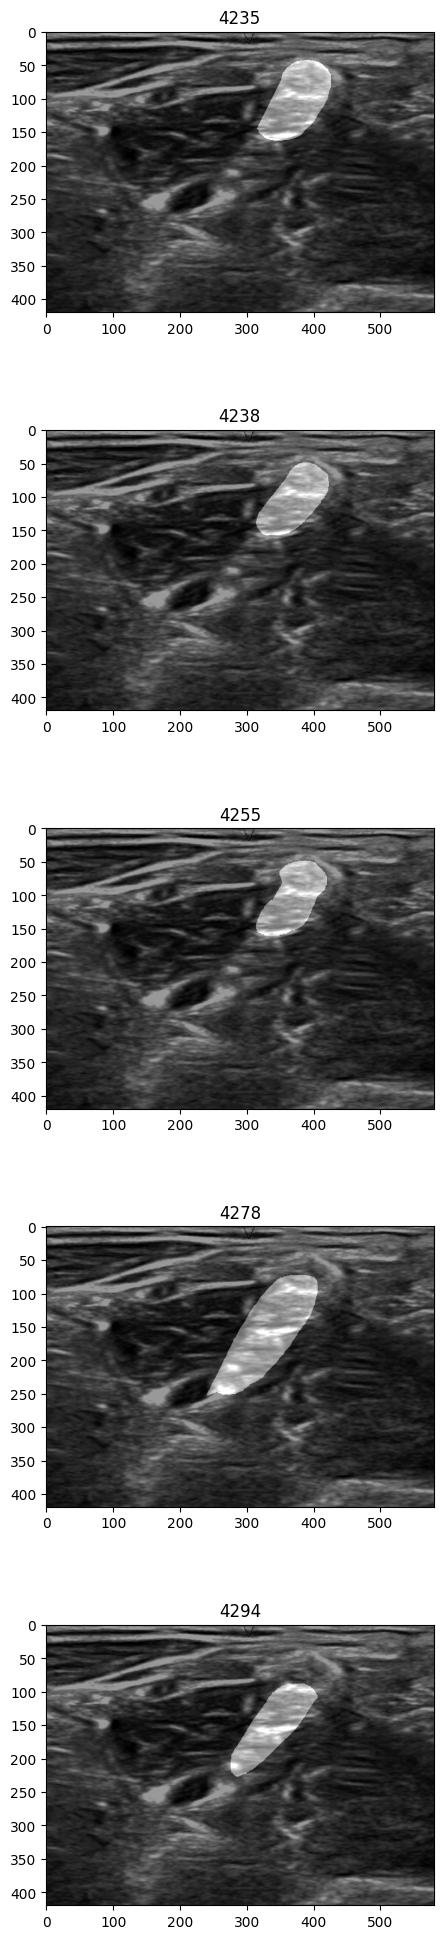

In [ ]:
k = 4235

fig, axes = plt.subplots(len(dup_dict[k]), figsize = (5, 5*(len(dup_dict[k]))))

for i, o in tqdm(enumerate(dup_dict[k])):
    axes[i].imshow(np.array(Image.open(images[o])), cmap = 'gray')
    axes[i].imshow(np.array(Image.open(masks[o])), alpha=0.4, cmap = 'gray')
    axes[i].title.set_text(o)

plt.show()

In [ ]:
to_remove = []
for pair in tqdm(dup_pairs):
    i1, i2 = pair
    msk1 = cv2.imread(masks[i1], cv2.IMREAD_GRAYSCALE)
    if msk1.any():
        to_remove.append(masks[i1])
    else:
        to_remove.append(masks[i2])
to_remove = list(set(to_remove))

100%|██████████| 262/262 [03:17<00:00,  1.33it/s]


## 1.2. Adjusting pixel brightness
For now, the nerves in the images are not so detectable to untrained eyes. Following the notebook https://www.kaggle.com/code/jhoward/don-t-see-like-a-radiologist-fastai?kernelSessionId=22162279, we adjust the brightness of the images and check if it improves the visibility of the nerves.

We start by checking the depth of the images.

In [ ]:
cv2.imread(trainpath + images[0], cv2.IMREAD_ANYDEPTH)

array([[  0, 106,  92, ...,  87,  86,  87],
       [  0, 191, 155, ..., 157, 157, 154],
       [  0, 248, 208, ..., 196, 194, 186],
       ...,
       [  0,  73,  54, ...,  25,  24,  23],
       [  0,  64,  51, ...,  23,  22,  19],
       [  0,  52,  49, ...,  25,  23,  23]], dtype=uint8)

In [ ]:
cv2.imread(trainpath + images[0], cv2.IMREAD_GRAYSCALE)

array([[  0, 106,  92, ...,  87,  86,  87],
       [  0, 191, 155, ..., 157, 157, 154],
       [  0, 248, 208, ..., 196, 194, 186],
       ...,
       [  0,  73,  54, ...,  25,  24,  23],
       [  0,  64,  51, ...,  23,  22,  19],
       [  0,  52,  49, ...,  25,  23,  23]], dtype=uint8)

### 1.2.1. Checking nerve appearance

In [ ]:
train_dataset = NerveDataset(mskfiles=train_msks, color=False, preprocess=None, augment=None)

In [ ]:
nerve_dataset = [train_dataset[i] for i in range(len(train_dataset)) if train_dataset[i][1].any()]
no_nerve_dataset = [train_dataset[i] for i in range(len(train_dataset)) if not train_dataset[i][1].any()]

We pick an arbitrary image with a nerve.

In [ ]:
img, msk = train_dataset[10]
msk.any()

True

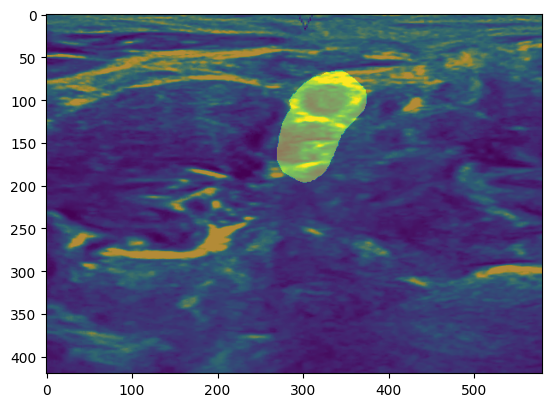

In [ ]:
plt.imshow(img[0,:,:])
plt.imshow(msk[0,:,:], alpha=0.4)

According to introductory materials on ultrasound images (for example, https://www.youtube.com/watch?v=icZmHvUt0hs), nerves can be identified as echogenic structures that are circular in shape. Brachial plexus will show up as a group of 3-6 nerves that are aligned vertically. We thus look for bright circles that appear in a vertical line.

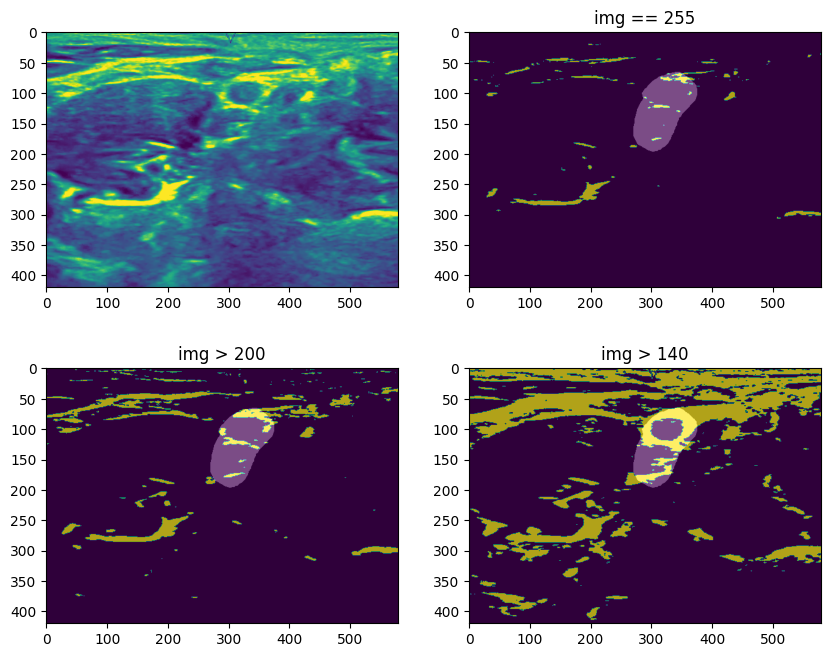

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,8))

axs[0,0].imshow(img[0,:,:]);
axs[1,0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[1,0].set_title('Original image');

extreme_img = np.zeros(img.shape)
extreme_img[np.where(img == 255)] = 255.
axs[0,1].imshow(extreme_img[0,:,:]);
axs[0,1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[0,1].set_title('img == 255');

extreme_img = np.zeros(img.shape)
extreme_img[np.where(img > 200)] = 255.
axs[1,0].imshow(extreme_img[0,:,:]);
axs[1,0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[1,0].set_title('img > 200');

extreme_img = np.zeros(img.shape)
extreme_img[np.where(img > 140)] = 255.
axs[1,1].imshow(extreme_img[0,:,:]);
axs[1,1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[1,1].set_title('img > 140');

### 1.2.2. Histogram equalization

Perhaps adjusting the brightness of each pixel as in https://www.kaggle.com/code/jhoward/don-t-see-like-a-radiologist-fastai might make the nerves more visible. We first adopt some functions from https://github.com/fastai/fastai/blob/master/nbs/60_medical.imaging.ipynb.

In [ ]:
def freqhist_bins(img, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = img.flatten()
    imsd.sort()
    t = np.concatenate(([0.001], np.arange(n_bins).astype(float)/n_bins+(1/2/n_bins), [0.999])) # why 0.001 and 0.999?
    t = (imsd.size*t).astype(int)
    return np.unique(imsd[t])

def hist_scaled(img, brks=100):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if isinstance(brks, int): brks = freqhist_bins(img, n_bins=brks)
    ys = np.linspace(0., 255., len(brks))
    x = img.flatten()
    x = np.interp(x, brks, ys)
    return np.clip(x.reshape(img.shape), 0., 255.)

Before we apply thse functions, we take a look at the historgram of the original image.


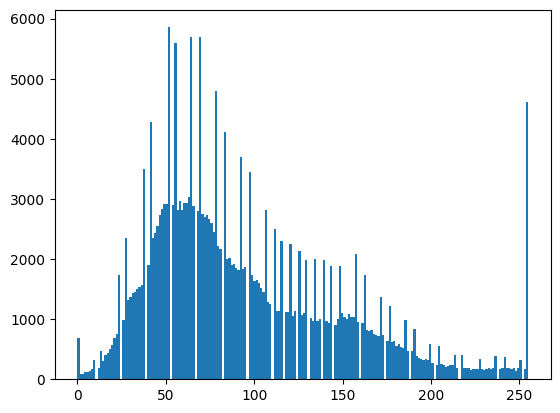

In [ ]:
n_bins = 200
plt.hist(img.flatten(), bins=n_bins);

The below is what the function we'll apply to the pixels roughly looks like.

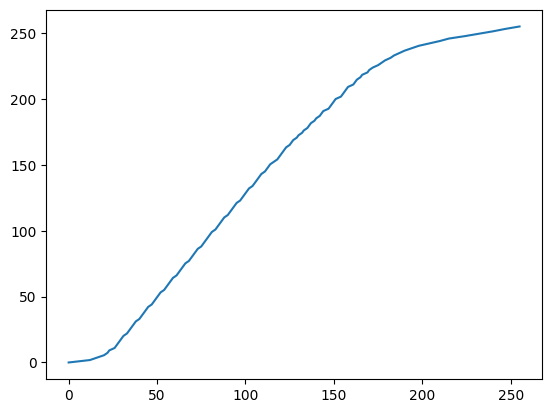

In [ ]:
imsd = img.flatten()
imsd.sort()

t = np.concatenate(([0.001], np.arange(n_bins).astype(float)/n_bins+(1/2/n_bins), [0.999]))
t = (imsd.size*t).astype(int)

brks = np.unique(imsd[t])
plt.plot(brks, torch.linspace(0,255,len(brks)));

The equalized histogram is shown below. Although equalization has removed some spikes, the histogram does not look completely equalized (why?)

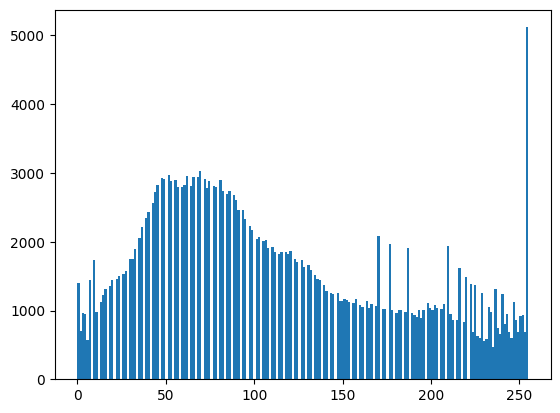

In [ ]:
ys = np.linspace(0., 255., len(brks))
x = img.flatten()
x = np.interp(x, brks, ys)
plt.hist(x, bins=n_bins);

The resulting image looks like the following.

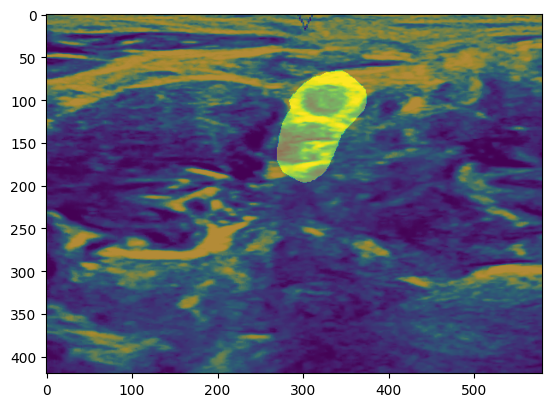

In [ ]:
new_img = x.reshape(img.shape)
plt.imshow(new_img[0,:,:])
plt.imshow(msk[0,:,:], alpha=0.4)

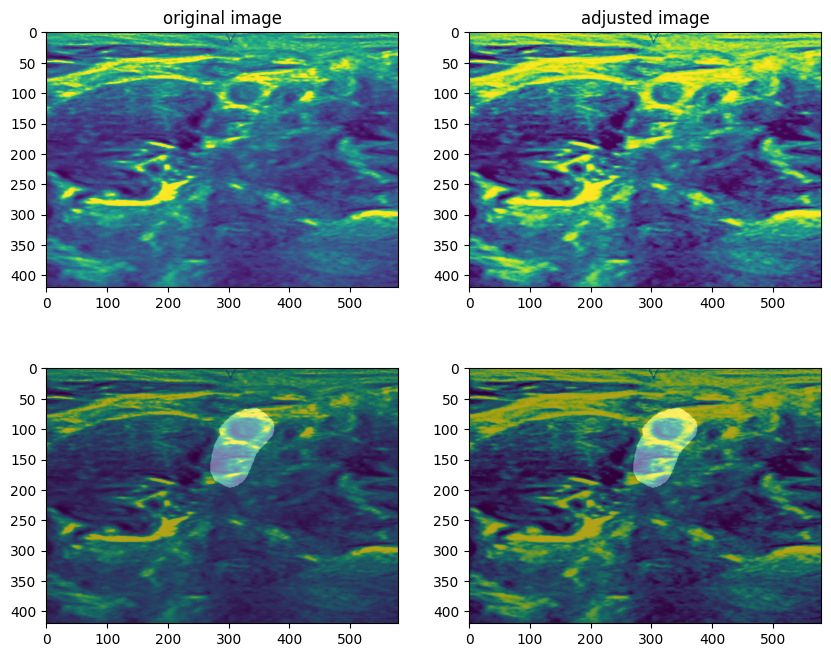

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,8))

axs[0,0].imshow(img[0,:,:]);
axs[0,0].set_title('original image');

axs[0,1].imshow(new_img[0,:,:]);
axs[0,1].set_title('adjusted image');

axs[1,0].imshow(img[0,:,:]);
axs[1,0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,1].imshow(new_img[0,:,:]);
axs[1,1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

The nerves are slightly more visible in the equalized image (as the histogram equalization makes more pixels brighter, including the circular boundaries of the nerves). One this one may notice the pixels that correspond to the nerve tend to be brighter (as expected). Let's compare the pixel histograms for 1. entire image, 2. nerve area, 3. area outside the nerves.

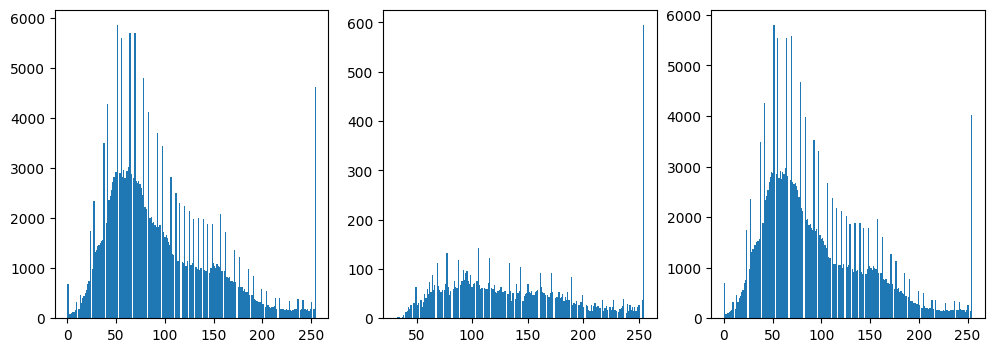

In [ ]:
nerve = img[np.where(msk > 0)]
elsewhere = img[np.where(msk == 0)]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(img.flatten(), bins=n_bins);
axs[1].hist(nerve.flatten(), bins=n_bins);
axs[2].hist(elsewhere.flatten(), bins=n_bins);

Since the histogram for nerve area looks pretty equalized (except for the huge spike at 255.), let's still try equalizing the histogram using the nerve area pixels only and see if it produces any better result (it might make some details in the nerve area more visible).

The below is the resulting histogram (for the entire image). As one might have expected, it makes the image darker in general (for example, there's now a huge spike on the left).

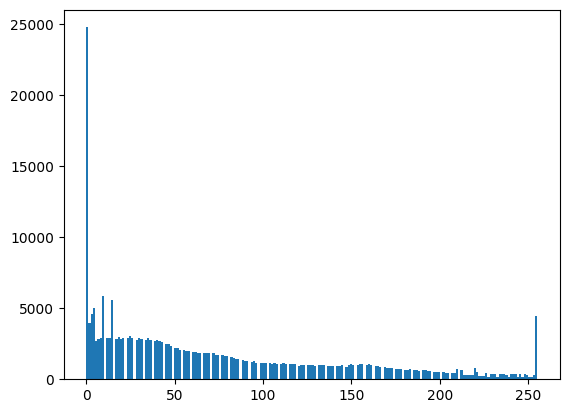

In [ ]:
nerve_adj_img = hist_scaled(img, brks = freqhist_bins(nerve, n_bins))
plt.hist(nerve_adj_img.flatten(), bins=n_bins);

Let's compare all three images.

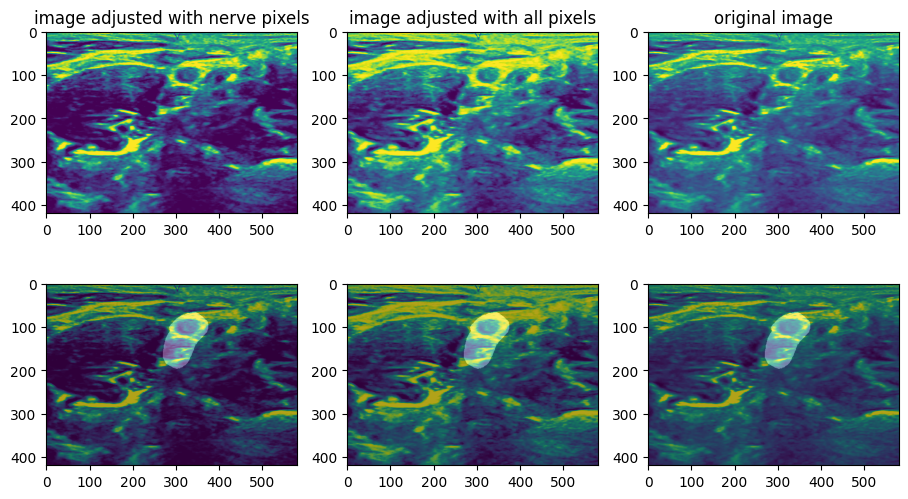

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(11, 6))

axs[0,0].imshow(nerve_adj_img[0,:,:]);
axs[0,0].set_title('image adjusted with nerve pixels');

axs[0,1].imshow(new_img[0,:,:]);
axs[0,1].set_title('image adjusted with all pixels');

axs[0,2].imshow(img[0,:,:]);
axs[0,2].set_title('original image');

axs[1,0].imshow(nerve_adj_img[0,:,:]);
axs[1,0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,1].imshow(new_img[0,:,:]);
axs[1,1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,2].imshow(img[0,:,:]);
axs[1,2].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

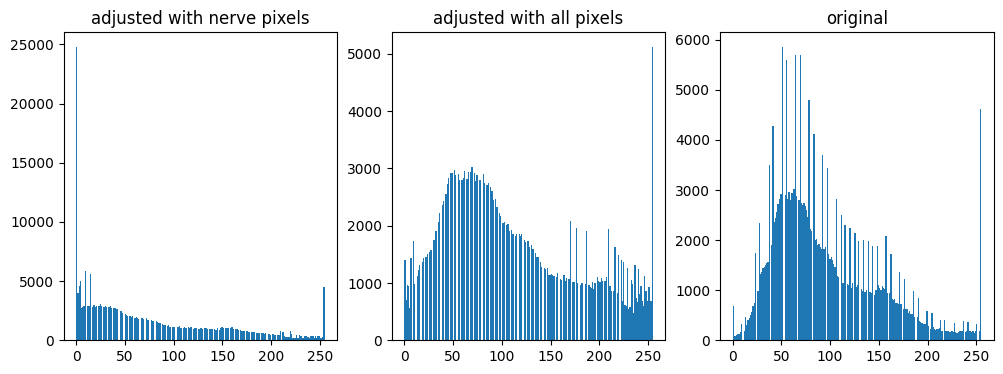

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))

axs[0].hist(nerve_adj_img.flatten(), bins=n_bins);
axs[0].set_title('adjusted with nerve pixels');

axs[1].hist(new_img.flatten(), bins=n_bins);
axs[1].set_title('adjusted with all pixels');

axs[2].hist(img.flatten(), bins=n_bins);
axs[2].set_title('original');

Although the nerves seem more visible in first two images, this example might be one of better examples where we can clearly see nerves to begin with. Thus let's try histogram equalization on other images to check if it actually has merits. We might be able to see if there are other characteristics of BP nerves we should pay attention to.

In [ ]:
i = random.randint(0, len(nerve_dataset))
print(i)
img, msk = nerve_dataset[i]
nerve = img[np.where(msk > 0)]

217


In [ ]:
n_bins = 100

Text(0.5, 1.0, 'pixels-nerve')

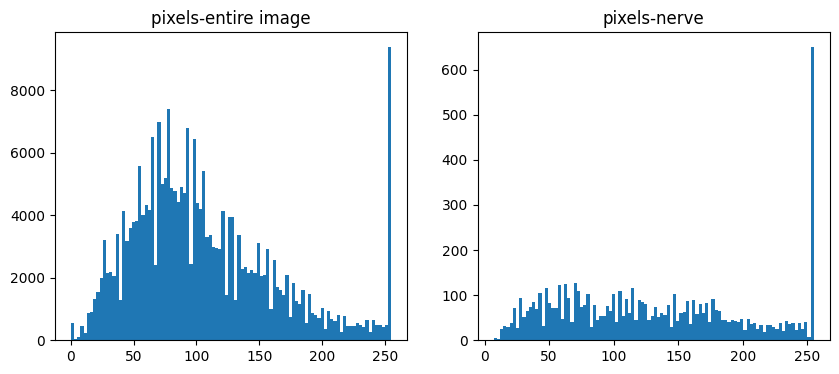

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(img.flatten(), bins=n_bins);
axs[0].set_title('pixels-entire image')

axs[1].hist(nerve.flatten(), bins=n_bins);
axs[1].set_title('pixels-nerve')

In [ ]:
adj_img = hist_scaled(img, brks = freqhist_bins(img, n_bins))
nerve_adj_img = hist_scaled(img, brks = freqhist_bins(nerve, n_bins))

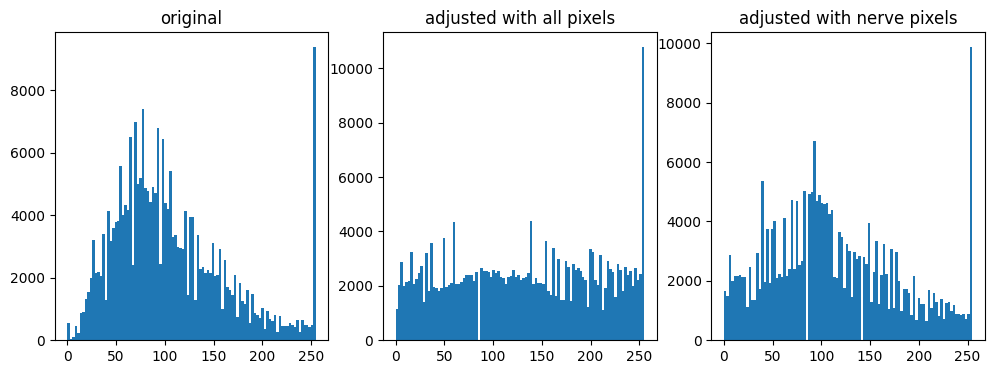

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))

axs[2].hist(nerve_adj_img.flatten(), bins=n_bins);
axs[2].set_title('adjusted with nerve pixels');

axs[1].hist(adj_img.flatten(), bins=n_bins);
axs[1].set_title('adjusted with all pixels');

axs[0].hist(img.flatten(), bins=n_bins);
axs[0].set_title('original');

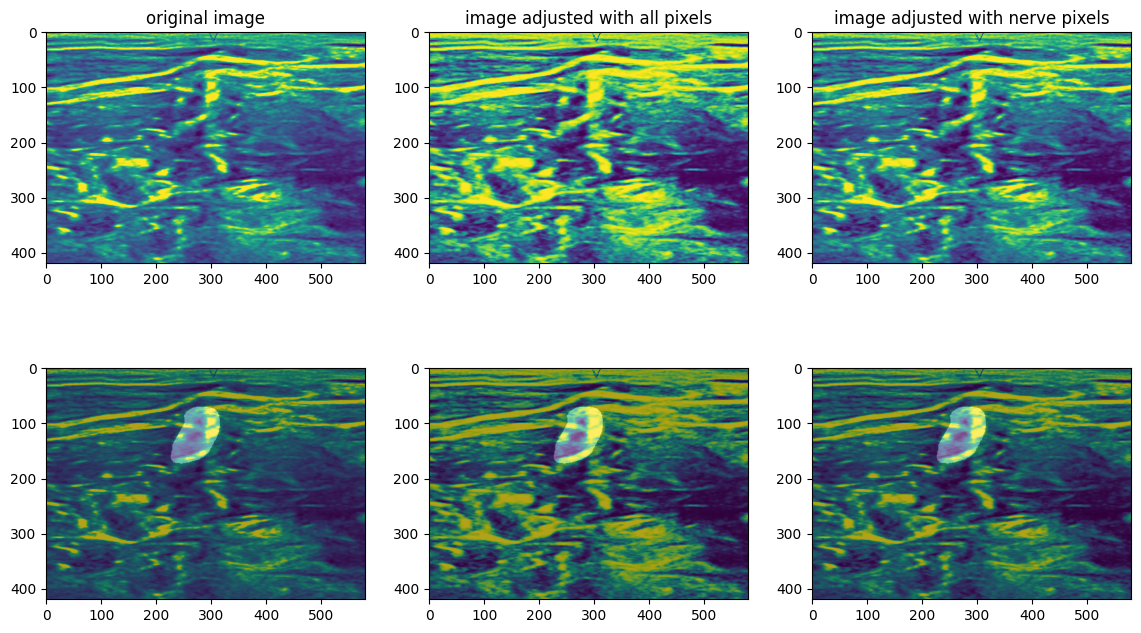

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(14, 8))

axs[0,2].imshow(nerve_adj_img[0,:,:]);
axs[0,2].set_title('image adjusted with nerve pixels');

axs[0,1].imshow(adj_img[0,:,:]);
axs[0,1].set_title('image adjusted with all pixels');

axs[0,0].imshow(img[0,:,:]);
axs[0,0].set_title('original image');

axs[1,2].imshow(nerve_adj_img[0,:,:]);
axs[1,2].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,1].imshow(adj_img[0,:,:]);
axs[1,1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,0].imshow(img[0,:,:]);
axs[1,0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

In this example, the nerves are quite visible but there are other features that rather look like nerves, at least to me. Although it's probably just me who are not used to looking at ultrasound images, in the future, let's check the ground truth mask is indeed correct.

Let's try another.

In [ ]:
i = random.randint(0, len(nerve_dataset))
print(i)
img, msk = nerve_dataset[i]
nerve = img[np.where(msk > 0)]

215


In [ ]:
n_bins = 100

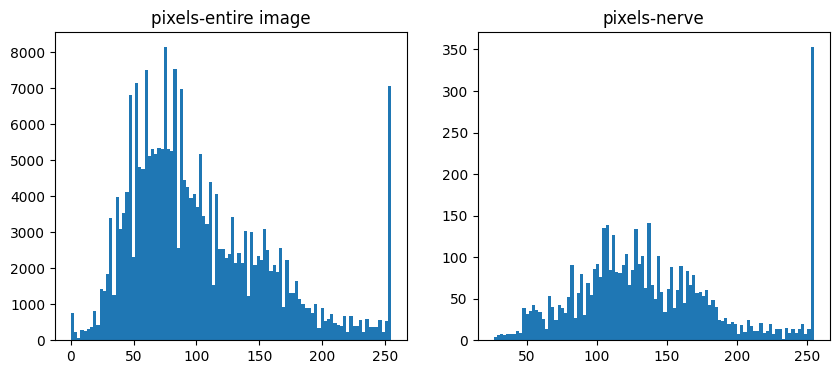

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(img.flatten(), bins=n_bins);
axs[0].set_title('pixels-entire image');

axs[1].hist(nerve.flatten(), bins=n_bins);
axs[1].set_title('pixels-nerve');

In [ ]:
adj_img = hist_scaled(img, brks = freqhist_bins(img, n_bins))
nerve_adj_img = hist_scaled(img, brks = freqhist_bins(nerve, n_bins))

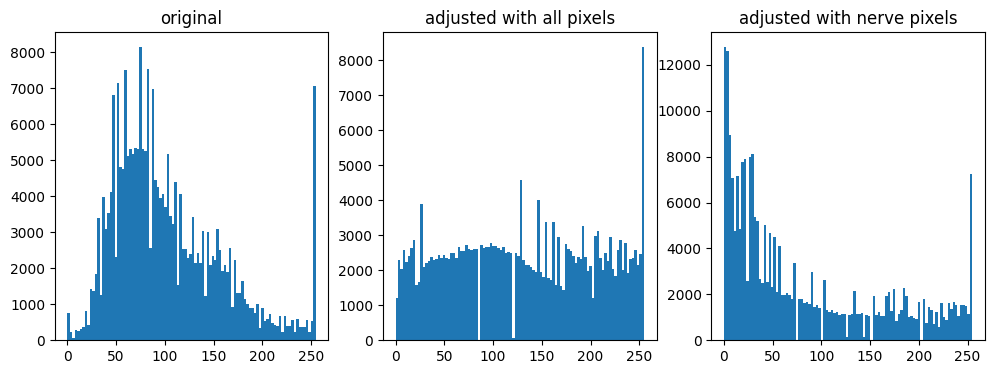

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))

axs[2].hist(nerve_adj_img.flatten(), bins=n_bins);
axs[2].set_title('adjusted with nerve pixels');

axs[1].hist(adj_img.flatten(), bins=n_bins);
axs[1].set_title('adjusted with all pixels');

axs[0].hist(img.flatten(), bins=n_bins);
axs[0].set_title('original');

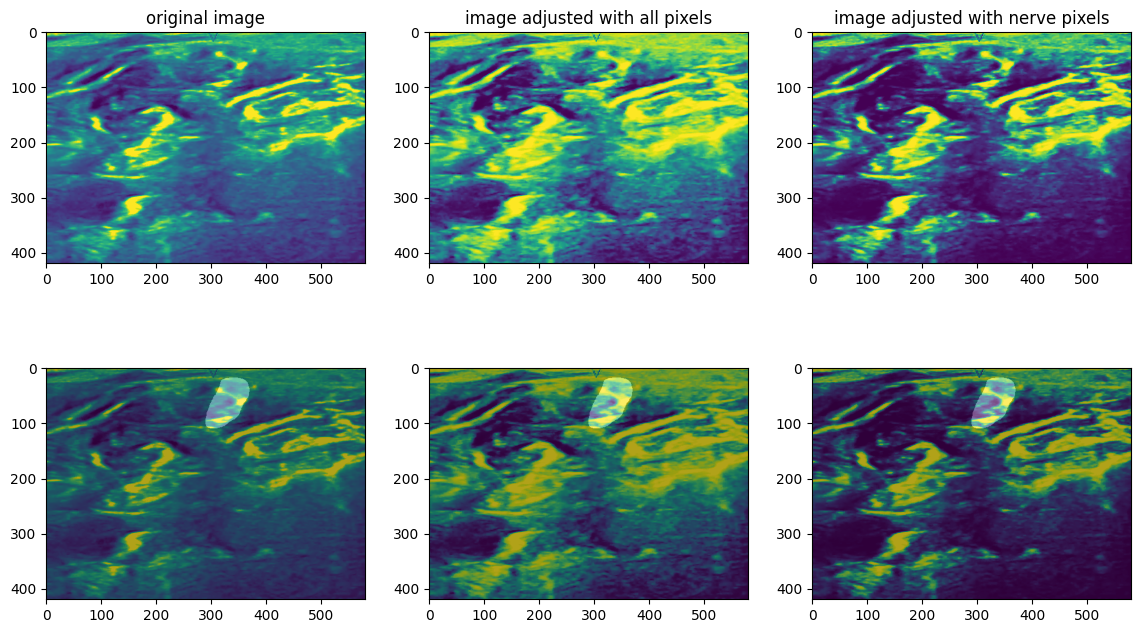

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(14, 8))

axs[0,2].imshow(nerve_adj_img[0,:,:]);
axs[0,2].set_title('image adjusted with nerve pixels');

axs[0,1].imshow(adj_img[0,:,:]);
axs[0,1].set_title('image adjusted with all pixels');

axs[0,0].imshow(img[0,:,:]);
axs[0,0].set_title('original image');

axs[1,2].imshow(nerve_adj_img[0,:,:]);
axs[1,2].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,1].imshow(adj_img[0,:,:]);
axs[1,1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,0].imshow(img[0,:,:]);
axs[1,0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

In this example, we see that adjusting pixel brightness with the nerve pixels, makes certain pixels of the nerve too dark (which is in some sense to be expected I guess). While the top nerve becomes more noticeable, the circular stuctures in the bottom three nerves becomes less noticeable.

In [ ]:
i = random.randint(0, len(nerve_dataset))
print(i)
img, msk = nerve_dataset[i]
nerve = img[np.where(msk > 0)]

47


In [ ]:
n_bins = 100

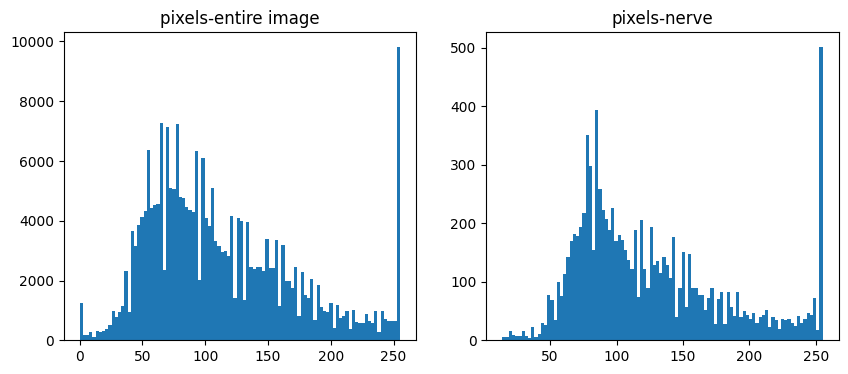

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(img.flatten(), bins=n_bins);
axs[0].set_title('pixels-entire image');

axs[1].hist(nerve.flatten(), bins=n_bins);
axs[1].set_title('pixels-nerve');

In [ ]:
adj_img = hist_scaled(img, brks = freqhist_bins(img, n_bins))
nerve_adj_img = hist_scaled(img, brks = freqhist_bins(nerve, n_bins))

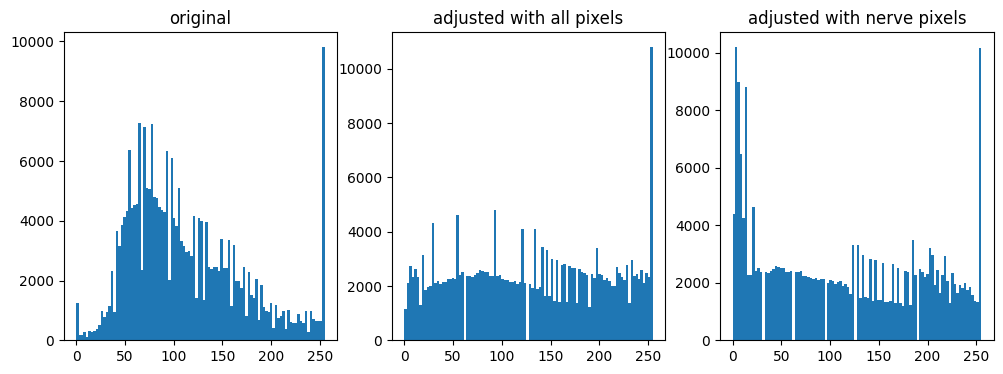

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))

axs[2].hist(nerve_adj_img.flatten(), bins=n_bins);
axs[2].set_title('adjusted with nerve pixels');

axs[1].hist(adj_img.flatten(), bins=n_bins);
axs[1].set_title('adjusted with all pixels');

axs[0].hist(img.flatten(), bins=n_bins);
axs[0].set_title('original');

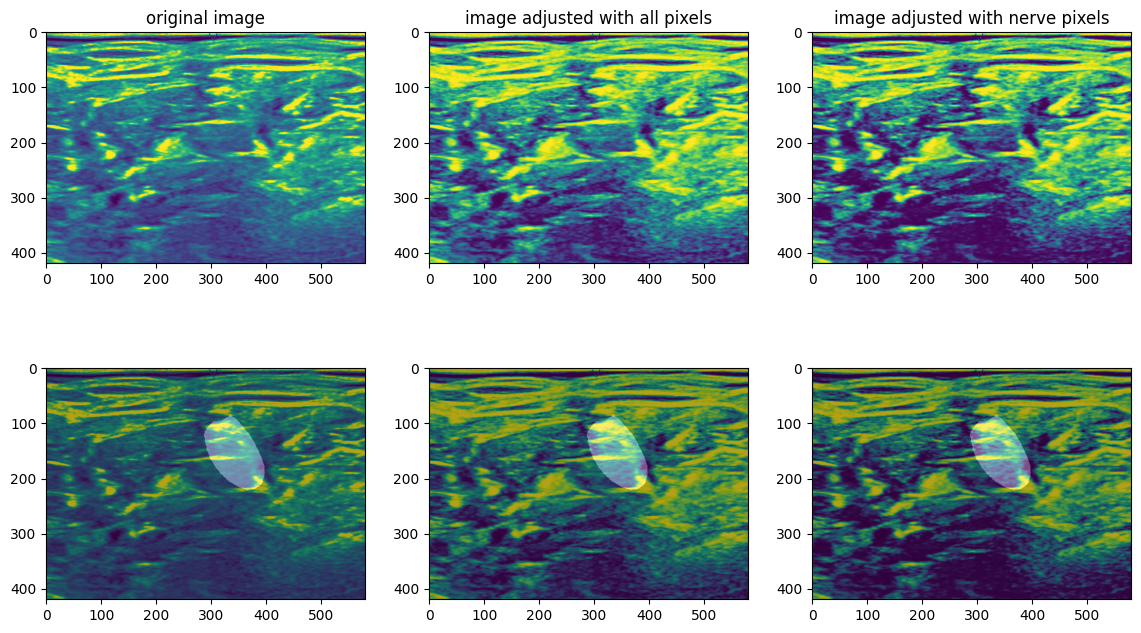

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(14, 8))

axs[0,2].imshow(nerve_adj_img[0,:,:]);
axs[0,2].set_title('image adjusted with nerve pixels');

axs[0,1].imshow(adj_img[0,:,:]);
axs[0,1].set_title('image adjusted with all pixels');

axs[0,0].imshow(img[0,:,:]);
axs[0,0].set_title('original image');

axs[1,2].imshow(nerve_adj_img[0,:,:]);
axs[1,2].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,1].imshow(adj_img[0,:,:]);
axs[1,1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

axs[1,0].imshow(img[0,:,:]);
axs[1,0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');

Just learned I can also use cv2.equalizeHist for this.

In [ ]:
i = random.randint(0, len(nerve_dataset))

In [ ]:
img, msk = nerve_dataset[i]

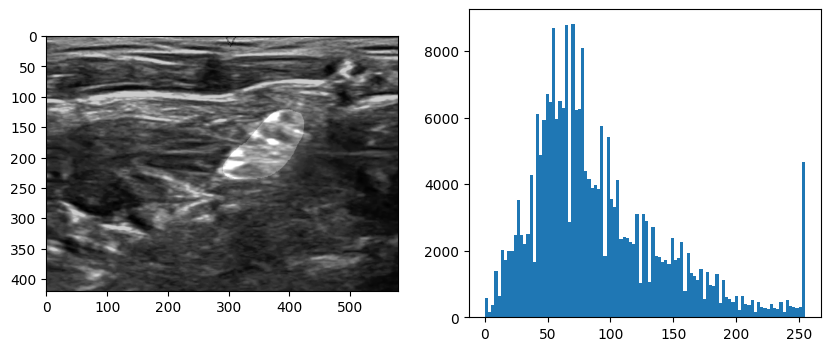

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(img[0,:,:], cmap='gray');
axs[0].imshow(msk[0,:,:], alpha=0.2, cmap='gray');

axs[1].hist(img.flatten(), bins=100);

In [ ]:
cv_adj_img = cv2.equalizeHist(img.astype('uint8')[0,:,:])

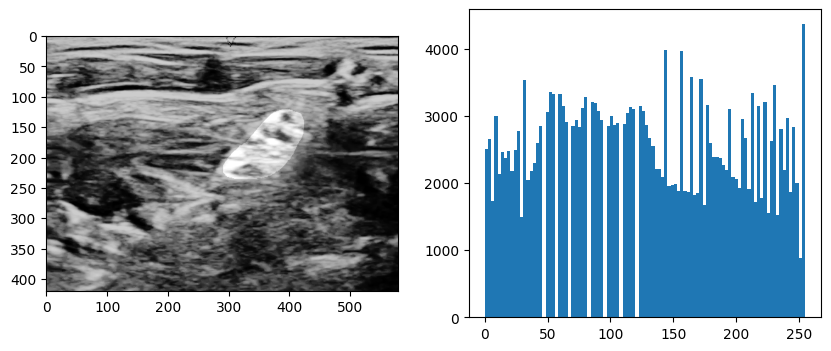

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(cv_adj_img, cmap='gray');
axs[0].imshow(msk[0,:,:], alpha=0.2, cmap='gray');

axs[1].hist(cv_adj_img.flatten(), bins=100);

### 1.2.3. CLAHE

We observed that adjusting the brightness globally does not always work. There must be a better way to adjust the brightness of each pixel locally and thus enhance the local contrast of the image. CLAHE looks promising ([article](https://www.analyticsvidhya.com/blog/2022/08/image-contrast-enhancement-using-clahe/#:~:text=Contrast%20Limited%20AHE%20(CLAHE)%20is,high%20accuracy%20and%20contrast%20limiting.) and [cv2 tutorial](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html)).

We start again with the same image from the previous section.


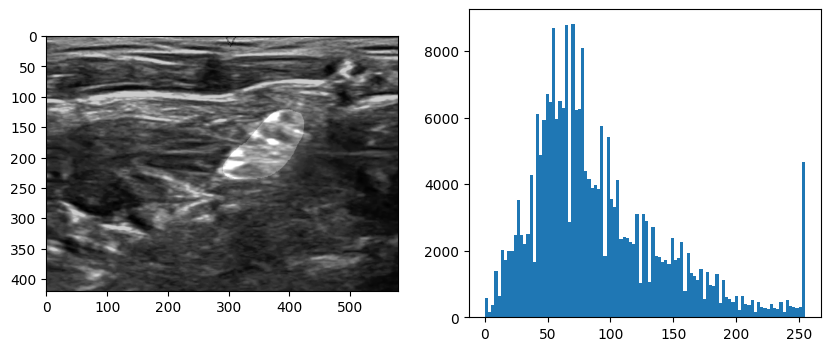

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(img[0,:,:], cmap='gray');
axs[0].imshow(msk[0,:,:], alpha=0.2, cmap='gray');

axs[1].hist(img.flatten(), bins=100);

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl_img = clahe.apply(img[0,:,:].astype('uint8'))

We first compare the image adjusted with CLAHE (left) with the original image (right).

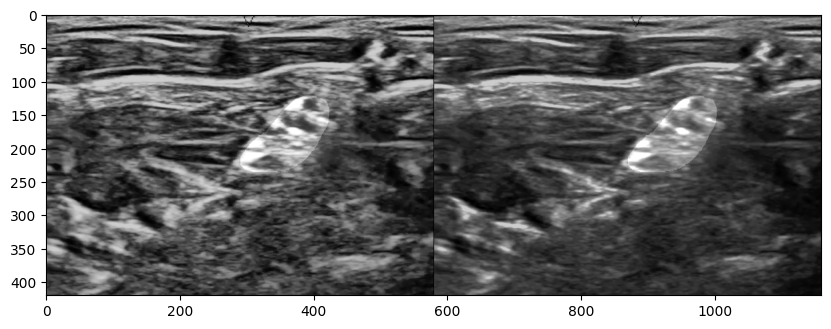

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.imshow(np.hstack((cl_img, img[0,:,:])), cmap='gray');
ax.imshow(np.hstack((msk[0,:,:], msk[0,:,:])), alpha=0.2, cmap='gray');

In the figure below, we compare the image adjusted with CLAHE (left) with the image adjusted by equalizing the histogram (right). For this specific example, we can observe the nerves are more visible in the CLAHE adjusted version.

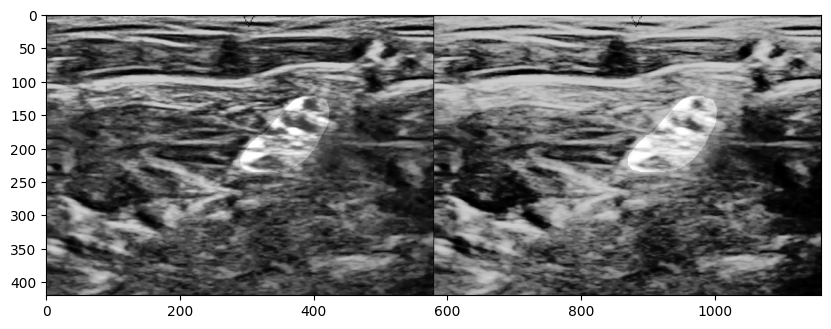

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.imshow(np.hstack((cl_img, cv_adj_img)), cmap='gray');
ax.imshow(np.hstack((msk[0,:,:], msk[0,:,:])), alpha=0.2, cmap='gray');

We apply CLAHE to another exmaple from the earlier section, where globally adjusting the brightness of pixels made certain features of the nerve less visible.

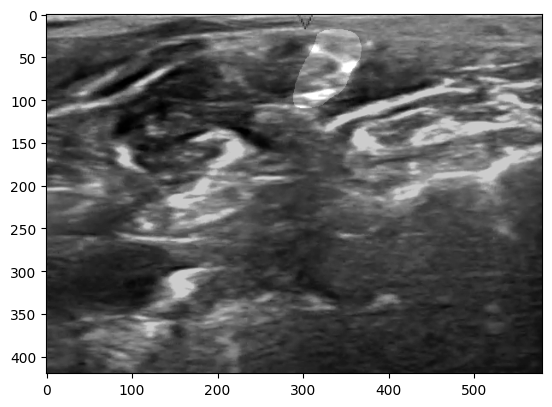

In [ ]:
i = 215
img, msk = nerve_dataset[i]

plt.imshow(img[0,:,:], cmap='gray');
plt.imshow(msk[0,:,:], alpha=0.2, cmap='gray');

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl_img = clahe.apply(img[0,:,:].astype('uint8'))
eh_img = cv2.equalizeHist(img.astype('uint8')[0,:,:])

Again the figure on the left shows the image adjusted with CLAHE whereas the figure on the right shows the image adjusted with histogram equalization.

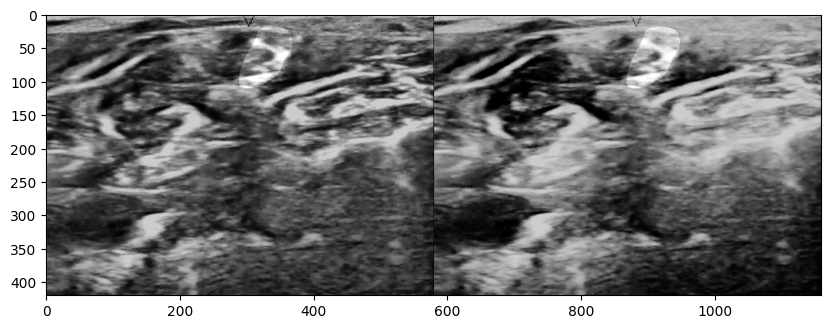

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.imshow(np.hstack((cl_img, eh_img)), cmap='gray');
ax.imshow(np.hstack((msk[0,:,:], msk[0,:,:])), alpha=0.2, cmap='gray');

My worry about CLAHE method is since it locally adjusts the brightness and contrast when the relative brightness of two regions can provide important information in identifying nerves (for example, one property that sets apart arteries/veins from nerves despite both of them being circular in shape is the fact that arteries/veins are anechoic and appear black/darker in ultrasound images). Nonetheless, it certainly makes the nerves more visible to human eyes (especially for untrained individual like myself) and although I might not apply CLAHE to the inputs of the models that will be presented in the following section, I might continue to use it to assess the segmentation done by the models.

Before we move on, let's try adjusting the two parameters (clipLimit, tileGridSize) for CLAHE and see if there's any particular combination that stands out.

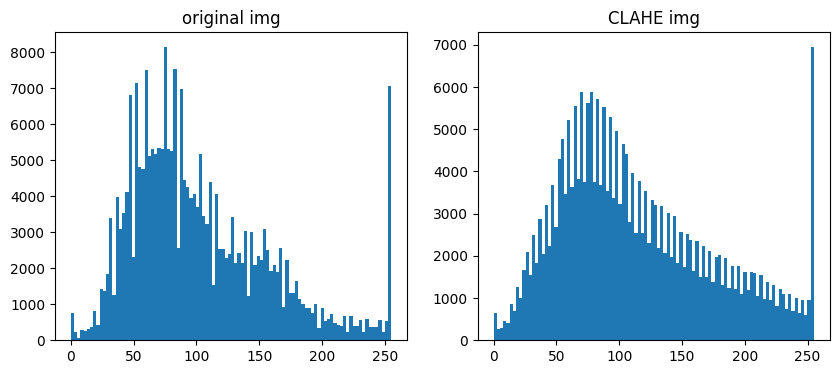

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))

axs[0].hist(img.flatten(), bins=100);
axs[0].set_title('original img');

axs[1].hist(cl_img.flatten(), bins=100);
axs[1].set_title('CLAHE img');

In [ ]:
type(range(3))

range

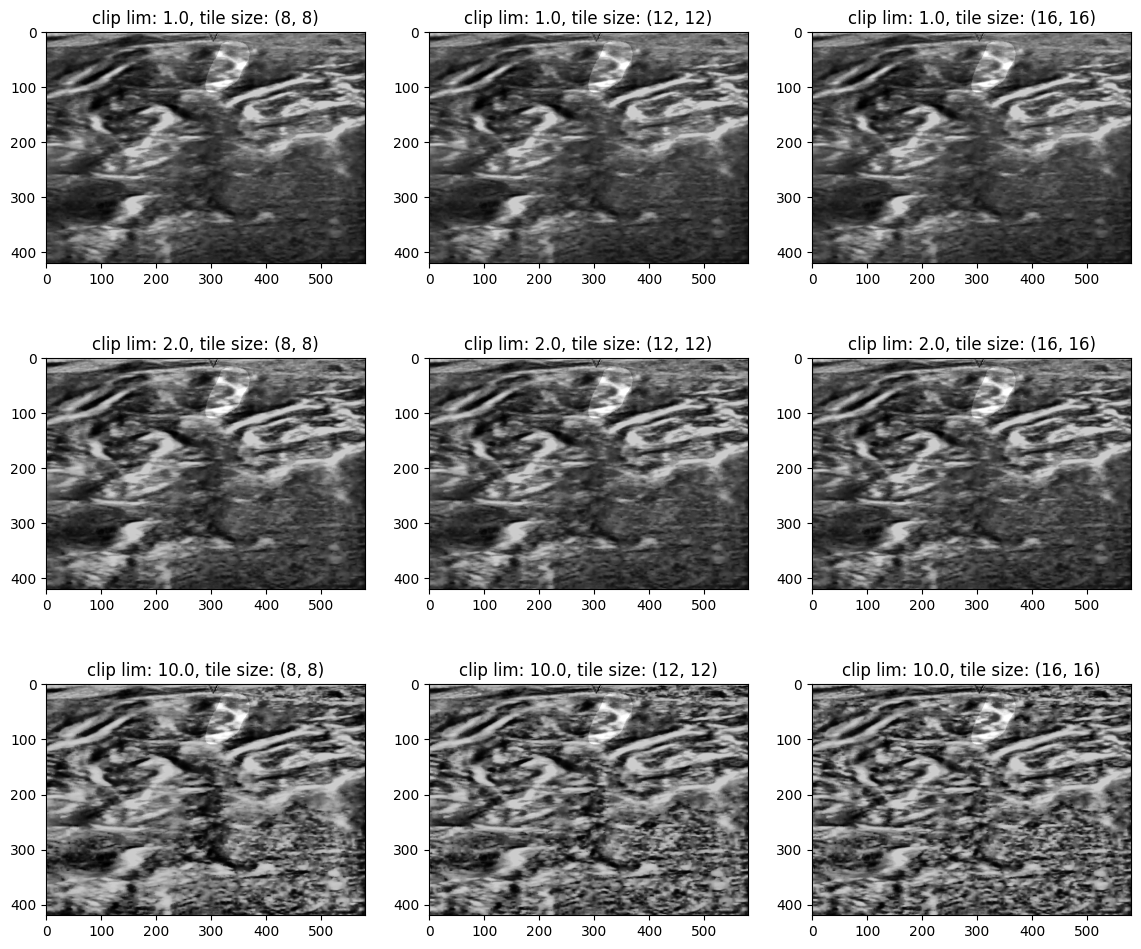

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(14, 12))

clipLims = [1., 2., 10.]
tileGridSizes = [(8,8), (12,12), (16,16)]

for i, j in itertools.product(range(len(clipLims)), range(len(tileGridSizes))):
    clipLim, tileGridSize = clipLims[i], tileGridSizes[j]

    clahe = cv2.createCLAHE(clipLimit=clipLim, tileGridSize=tileGridSize)
    cl_img = clahe.apply(img[0,:,:].astype('uint8'))

    axs[i,j].imshow(cl_img, cmap='gray');
    axs[i,j].imshow(msk[0,:,:], alpha=0.2, cmap='gray');
    axs[i,j].set_title('clip lim: {0}, tile size: {1}'.format(clipLim, tileGridSize));

Just checking if CLAHE indeed makes detecting the circular strcuture easier.

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl_img = clahe.apply(img[0,:,:].astype('uint8'))

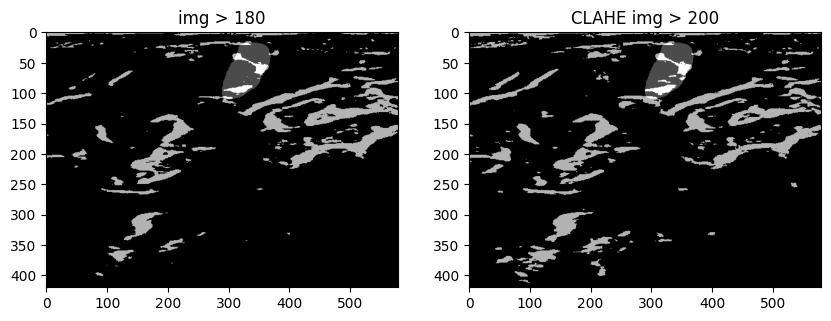

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))

thres1, thres2 = 180, 200

extreme_img = np.zeros(img.shape)
extreme_img[np.where(img > thres1)] = 255.
axs[0].imshow(extreme_img[0,:,:], cmap='gray');
axs[0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[0].set_title('img > ' + str(thres1));

extreme_img = np.zeros(cl_img.shape)
extreme_img[np.where(cl_img > thres2)] = 255.
axs[1].imshow(extreme_img, cmap='gray');
axs[1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[1].set_title('CLAHE img > ' + str(thres2));

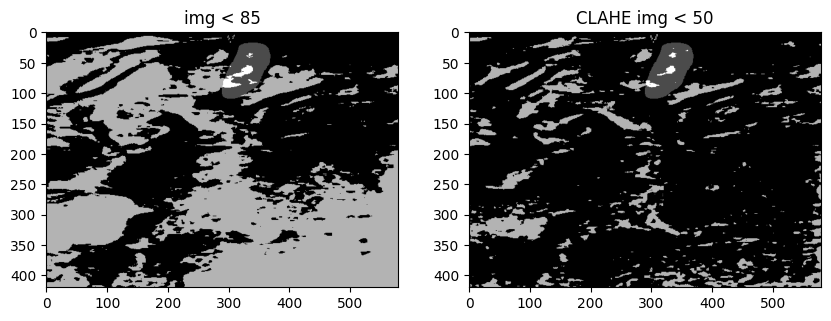

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))

thres1, thres2 = 85, 50

extreme_img = np.zeros(img.shape)
extreme_img[np.where(img < thres1)] = 255.
axs[0].imshow(extreme_img[0,:,:], cmap='gray');
axs[0].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[0].set_title('img < ' + str(thres1));

extreme_img = np.zeros(cl_img.shape)
extreme_img[np.where(cl_img < thres2)] = 255.
axs[1].imshow(extreme_img, cmap='gray');
axs[1].imshow(msk[0,:,:], alpha=0.3, cmap='gray');
axs[1].set_title('CLAHE img < ' + str(thres2));

# 2. Create train/validation/test set

Since I only have limited amount of compute units, I decided to experiment with a small subset of the original dataset. These datasets are saved in data folder.

In [ ]:
stratify = [has_nerve(o) for o in masks]
_, train_test_msks = train_test_split(masks, test_size = 0.3, stratify=stratify)
train_test_stratify = [has_nerve(o) for o in train_test_msks]
train_msks, test_msks = train_test_split(train_test_msks, test_size = 0.15, stratify=train_test_stratify)
train_stratify = [has_nerve(o) for o in train_msks]
train_msks, valid_msks = train_test_split(train_msks, test_size = 0.15, stratify=train_stratify)

In [ ]:
len(masks), len(train_test_msks), len(train_msks), len(valid_msks)

(5496, 1649, 1190, 211)

## 2.1. Mask sizes/distribution

Check the mask sizes/distribution in the newly created dataset to gauge how "unbalanced" the dataset is.

In [ ]:
def has_nerve(mask):
    o = cv2.imread(trainpath+mask, cv2.IMREAD_GRAYSCALE)
    return 1 if o.any() else 0

In [ ]:
sum(stratify)/len(stratify)

0.39737991266375544

In [ ]:
mask_sizes = []
for o in train_msks:
    msk = cv2.imread(trainpath+o, cv2.IMREAD_GRAYSCALE)/255
    mask_sizes.append(msk.sum())

w, h = msk.shape

In [ ]:
mask_sizes = np.array(mask_sizes)

In [ ]:
len(np.where(mask_sizes>0)[0])/len(train_msks)

0.39663865546218485

This ratio also gives us the lower bound for a reasonable model performance, in other words, how badly a base model--that predicts no nerve in any case--would perform.

In [ ]:
sum([1 if has_nerve(o) else 0 for o in train_msks])/len(train_msks)

0.39663865546218485

In [ ]:
nerve_i = np.where(mask_sizes>0)
np.mean(mask_sizes[nerve_i]/(w*h)), np.std(mask_sizes[nerve_i]/(w*h))

(0.029280513345022404, 0.0074315059530314495)